Original: https://arxiv.org/abs/1707.07961

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import keras.backend as K
from google.colab import drive
import gc

In [ ]:
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 5.5MB 23.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=9ade3b08935048ec32c16a8452f04a3758e0c8c8350c25370877f75e96b5464f
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
drive.mount(u"/contents/")

Mounted at /contents/


# Dataset Construction

In [ ]:
tickers = "AAPL MSFT MMM MRO CLX CAT JPM GS AXP DLTR AMD NFLX FCX AZO KO AMZN"
data = yf.download(tickers, start="2010-01-01", end="2018-12-31")
## ignoring the fact it isnt div adjusted
rets = data["Adj Close"].apply(np.log).diff()[1:]
#rets /= rets.rolling(10, min_periods=10).std()
#rets = rets[10:]

[*********************100%***********************]  16 of 16 completed


In [ ]:
gc.collect()

15515

In [ ]:
rets.shape

(2262, 16)

In [ ]:
time_series_len = 40
input_dim = 16

train_length = 1600
train_rets = rets.values[:train_length, :]
test_rets = rets.values[train_length:, :]
def create_x_data(rets, time_series_len):
    num_time_series = len(rets) - time_series_len + 1
    x_data = []
    for i in range(num_time_series):
        x_data.append(rets[i:time_series_len+i,:input_dim])
    x_data = np.asarray(x_data, dtype=np.float32)
    return x_data
train_x_data = create_x_data(train_rets, time_series_len)
test_x_data = create_x_data(test_rets, time_series_len)

In [ ]:
train_x_data.shape, test_x_data.shape

((1561, 40, 16), (623, 40, 16))

In [ ]:
train_future_returns = create_future_returns(train_rets, len(train_x_data)-1)
test_future_returns = create_future_returns(test_rets, len(test_x_data)-1)
train_input_data = train_x_data[1:]
test_input_data = test_x_data[1:]
train_input_data.shape, test_input_data.shape, train_future_returns.shape, test_future_returns.shape

((1560, 40, 16), (622, 40, 16), (1560, 40, 16), (622, 40, 16))

# Deep RAE Portfolio

In [ ]:
def negative_mean_variance_utility(y_true,y_pred):
  # y_pred is the portfolio weights
  # y_true is the returns!
  # we want to compute average portfolio return
  # mean-variance utility! similar to an exponential utility with the same risk aversion
  return -K.mean(K.sum(K.sum(y_pred * y_true, axis=-1), axis=-1)) + risk_aversion * K.mean(K.std(K.sum(y_pred * y_true, axis=-1), axis=-1))
  #return (callprice + kb.sum(y_pred * y_true,axis=-1) - kb.maximum(S_0 + kb.sum(y_true,axis=-1) - K,0.))**2
def negative_entropic_utility(y_true,y_pred):
  return K.mean(K.exp(-risk_aversion*K.sum(K.sum(y_pred * y_true, axis=-1), axis=-1)))
def create_future_returns(rets, num_time_series_len):
  future_returns = []
  for i in range(num_time_series_len):
      future_returns.append(rets[i+1:time_series_len+i+1,:input_dim])
  future_returns = np.asarray(future_returns, dtype=np.float32)
  return future_returns
def portfolio_performance(train_portfolio_weights, test_portfolio_weights):
  train_portfolio_return_averages = np.mean(np.sum(train_portfolio_weights * train_future_returns, axis=-1), axis=-1)
  test_portfolio_return_averages = np.mean(np.sum(test_portfolio_weights * test_future_returns, axis=-1), axis=-1)
  return train_portfolio_return_averages, test_portfolio_return_averages

In [ ]:
"""
Recurrent Auto-Encoder
Original paper: https://arxiv.org/abs/1707.07961
"""
### Model Creation

class LSTM_Sequential_State(tf.keras.Model):
  def __init__(self, time_series_len, input_dim, LSTM_units):
    '''
    This is a rolling version of LSTM, 
    which applies the ordinary LSTM to a dataset 
    and returns all the cell states and hidden states.
    '''
    super(LSTM_Sequential_State, self).__init__()
    self.time_series_len = time_series_len
    self.input_dim = input_dim
    self.LSTM_units = LSTM_units

    self.inputs = tf.keras.Input((self.time_series_len, self.input_dim))
    self.rnn = tf.keras.layers.LSTM(self.LSTM_units, return_state=True)

    def expand(x):
        return K.expand_dims(x, 1)

    self.expand_layer = tf.keras.layers.Lambda(expand, output_shape=lambda s: (s[0], 1, s[1]))

  @staticmethod
  def get_indexer(t):
        return tf.keras.layers.Lambda(lambda x, t: x[:, t, :], arguments={'t':t}, output_shape=lambda s: (s[0], s[2]))

  def call(self, inputs):
    state = None
    states = [] # list of (h, c) tuples
    outputs = []
    h_states = []
    c_states = []
    for t in range(self.time_series_len):
        input_t = LSTM_Sequential_State.get_indexer(t)(inputs)  # basically input_t = inputs[:, t, :]
        input_t = self.expand_layer(input_t)
        output_t, h, c = self.rnn(input_t, initial_state=state)
        state = h, c
        states.append(state)
        h_states.append(h)
        c_states.append(c)
        outputs.append(output_t)

    c_states_layer = tf.keras.layers.Concatenate(axis=-1)(c_states)
    c_reshape_layer = tf.keras.layers.Reshape((self.time_series_len,self.LSTM_units))(c_states_layer)
    h_states_layer = tf.keras.layers.Concatenate(axis=-1)(h_states)
    h_reshape_layer = tf.keras.layers.Reshape((self.time_series_len,self.LSTM_units))(h_states_layer)
    output = tf.keras.layers.concatenate((c_reshape_layer, h_reshape_layer), axis=-1)
    return output

class RAE_Model(tf.keras.Model):
  def __init__(self, time_series_len, input_dim, LSTM_units, compression_units, regularization_coefficient):
    '''
    time_series_len: the length of time series, which is the second dimension of the dataset
    input_dim: the number of time series, which is the third dimension of the dataset
    LSTM_units: the number of units used in LSTM layer
    compression_units: the number of units in the Dense layer which acts on each output at each time point
    '''
    super(RAE_Model, self).__init__()
    self.time_series_len = time_series_len
    self.input_dim = input_dim
    self.LSTM_units = LSTM_units
    self.compression_units = compression_units
    self.regularizer = tf.keras.regularizers.L1(regularization_coefficient)

    self.lss = LSTM_Sequential_State(time_series_len, input_dim, LSTM_units)
    self.d = tf.keras.layers.Dense(compression_units, kernel_regularizer=self.regularizer, bias_regularizer=self.regularizer)
    self.FF1 = tf.keras.layers.TimeDistributed(self.d)

    self.lss_scale = LSTM_Sequential_State(time_series_len, compression_units, LSTM_units)
    self.scale_up = tf.keras.layers.Dense(input_dim, kernel_regularizer=self.regularizer, bias_regularizer=self.regularizer)
    self.FF2 = tf.keras.layers.TimeDistributed(self.scale_up)

  def call(self, inputs):
    x = self.lss(inputs) # using default, ouputs: (1, 90, 10) 10: 2*5, where 5 is LSTM units
    x = self.FF1(x) # using default, ouputs: (1, 90, 1) -> latent time series (univariate)
    x = self.lss_scale(x) # check the dimension of x here
    x = self.FF2(x)
    return x
    # freeze until one of the layers, and use the prior layers together with a feed-forward for forecasting future time series

  def get_encoder(self):
    return lambda inputs : self.FF1(self.lss(inputs))

In [ ]:
class RAE_Portfolio(tf.keras.Model):
  def __init__(self, time_series_len, input_dim, LSTM_units, compression_units, regularization_coefficient):
    '''
    time_series_len: the length of time series, which is the second dimension of the dataset
    input_dim: the number of time series, which is the third dimension of the dataset
    LSTM_units: the number of units used in LSTM layer
    compression_units: the number of units in the Dense layer which acts on each output at each time point

    output: a long-only no-leverage portfolio for input_dim stocks
    '''
    super(RAE_Portfolio, self).__init__()
    self.time_series_len = time_series_len
    self.input_dim = input_dim
    self.LSTM_units = LSTM_units
    self.compression_units = compression_units
    self.regularizer = tf.keras.regularizers.L1(regularization_coefficient)

    self.lss = LSTM_Sequential_State(time_series_len, input_dim, LSTM_units)
    self.d = tf.keras.layers.Dense(compression_units, kernel_regularizer=self.regularizer, bias_regularizer=self.regularizer)
    self.FF1 = tf.keras.layers.TimeDistributed(self.d)

    self.lss_scale = LSTM_Sequential_State(time_series_len, compression_units, LSTM_units)
    self.scale_up = tf.keras.layers.Dense(input_dim, kernel_regularizer=self.regularizer, bias_regularizer=self.regularizer, activation="softmax")
    self.FF2 = tf.keras.layers.TimeDistributed(self.scale_up)

  def call(self, inputs):
    x = self.lss(inputs) # using default, ouputs: (1, 90, 10) 10: 2*5, where 5 is LSTM units
    x = self.FF1(x) # using default, ouputs: (1, 90, 1) -> latent time series (univariate)
    x = self.lss_scale(x) # check the dimension of x here
    x = self.FF2(x)
    return x
    # freeze until one of the layers, and use the prior layers together with a feed-forward for forecasting future time series

  def get_encoder(self):
    return lambda inputs : self.FF1(self.lss(inputs))

In [ ]:
LSTM_units = 5
compression_units = 8
regularization_coefficient = 4e-2
risk_aversion = 1.0
rae_portfolio_constructor = RAE_Portfolio(time_series_len=time_series_len, LSTM_units=LSTM_units, input_dim=input_dim, compression_units=compression_units, regularization_coefficient=regularization_coefficient)

In [ ]:
tf.random.set_seed(42)
rae_portfolio_constructor.compile(optimizer="adam", loss=negative_entropic_utility)
h = rae_portfolio_constructor.fit(train_input_data, train_future_returns, epochs=100, verbose=1, validation_data=(test_input_data, test_future_returns), batch_size=200)

Epoch 1/100
8/8 [==============================] - 104s 3s/step - loss: 3.3996 - val_loss: 3.3274
Epoch 2/100
8/8 [==============================] - 1s 116ms/step - loss: 3.3190 - val_loss: 3.2524
Epoch 3/100
8/8 [==============================] - 1s 112ms/step - loss: 3.2442 - val_loss: 3.1790
Epoch 4/100
8/8 [==============================] - 1s 116ms/step - loss: 3.1702 - val_loss: 3.1075
Epoch 5/100
8/8 [==============================] - 1s 111ms/step - loss: 3.0993 - val_loss: 3.0375
Epoch 6/100
8/8 [==============================] - 1s 111ms/step - loss: 3.0300 - val_loss: 2.9690
Epoch 7/100
8/8 [==============================] - 1s 139ms/step - loss: 2.9618 - val_loss: 2.9023
Epoch 8/100
8/8 [==============================] - 1s 124ms/step - loss: 2.8958 - val_loss: 2.8364
Epoch 9/100
8/8 [==============================] - 1s 117ms/step - loss: 2.8292 - val_loss: 2.7709
Epoch 10/100
8/8 [==============================] - 1s 145ms/step - loss: 2.7609 - val_loss: 2.7065
Epoch 11/1

In [ ]:
gc.collect()

1712679

(0.96, 1.01)

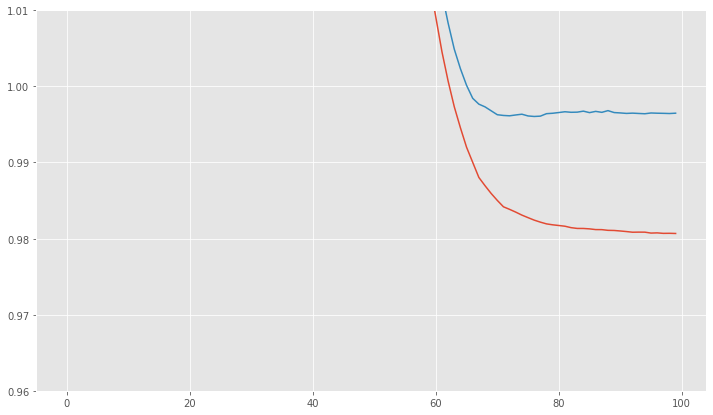

In [ ]:
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(111)
ax.plot(h.history["loss"])
ax.plot(h.history["val_loss"])
ax.set_ylim((0.96, 1.01))

# Performance Evaluation

In [ ]:
train_portfolio_weights = rae_portfolio_constructor.predict(train_input_data)
test_portfolio_weights = rae_portfolio_constructor.predict(test_input_data)
train_portfolio_return_averages, test_portfolio_return_averages = portfolio_performance(train_portfolio_weights, test_portfolio_weights)

In [ ]:
train_portfolio_weights[0,-1,:]

array([8.3910971e-04, 8.3134871e-04, 8.4211474e-04, 8.3062396e-04,
       9.8748559e-01, 8.3521364e-04, 8.2992000e-04, 8.2600914e-04,
       8.4006414e-04, 8.2515879e-04, 8.3669252e-04, 8.2841056e-04,
       8.2889013e-04, 8.3767326e-04, 8.3026837e-04, 8.5300434e-04],
      dtype=float32)

In [ ]:
np.mean(train_portfolio_return_averages), np.mean(test_portfolio_return_averages)

(0.0007768986, 0.00042050137)

## Regularization coefficient = 2e-2

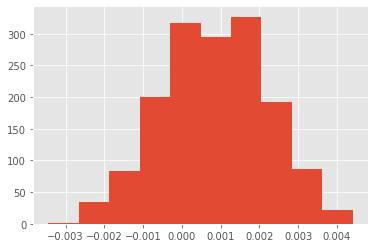

In [ ]:
plt.hist(train_portfolio_return_averages)
plt.show()

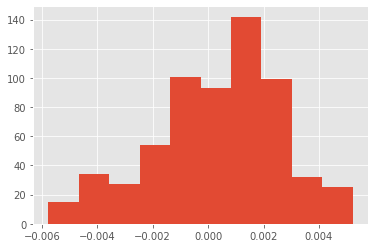

In [ ]:
plt.hist(test_portfolio_return_averages)
plt.show()

## Regularization coefficient = 4e-2

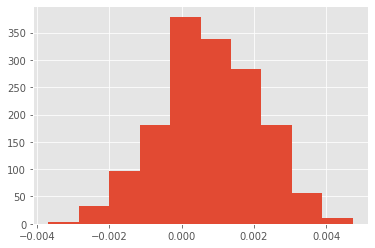

In [ ]:
plt.hist(train_portfolio_return_averages)
plt.show()

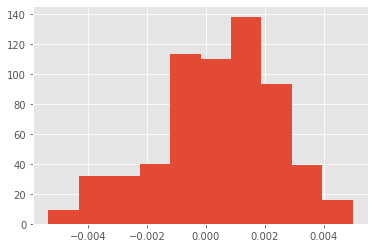

In [ ]:
plt.hist(test_portfolio_return_averages)
plt.show()

## Regularization coefficient = 8e-2

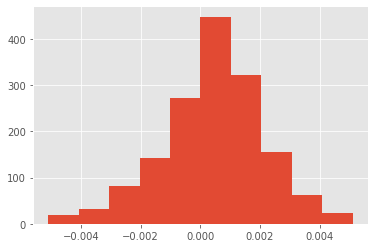

In [ ]:
plt.hist(train_portfolio_return_averages)
plt.show()

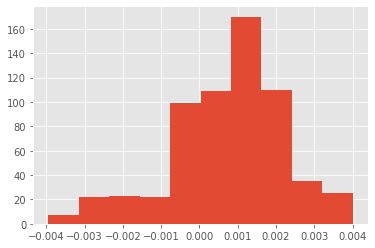

In [ ]:
plt.hist(test_portfolio_return_averages)
plt.show()